# Analyse de données du naufrage du Titanic

Méthodes Statistiques pour méga-données, mai 2016

Benjamin Rouif
Stanislas Thiery

**Procédure d'instalation**:

Nous recommendons de placer ce notebook dans un dossier et d'initialiser un environement Python virtuel grâce à Virtuelenv. Il est également nécessaire d'installer Graphviz pour obtenir les arbres de régression en image .png (pour cela, on fera `brew install graphviz`).

Les modules Python requis pour ce notebook sont:
* matplotlib
* numpy
* pandas
* sklearn
* IPython
* pydot
* seaborn
* random

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import datasets, svm, linear_model, cross_validation, tree, ensemble, neighbors, naive_bayes
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from IPython.display import Image 
from sklearn.externals.six import StringIO  
import pydot
import seaborn as sns
import statsmodels.api as sm 
import random

## Chargement des donnée

In [3]:
df = pd.read_csv("data/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 1. Analyse statistique des données

Tout d'abord, on regarde les données brutes issues du site Kaggle.

In [144]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Ticket_Party,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NoClue,Cabin_T
0,1,0,3,"Braund, Mr. Owen Harris",1.0,22.0,1.0,0.0,A/5 21171,7.2500,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,38.0,1.0,0.0,PC 17599,71.2833,...,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0.0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,35.0,1.0,0.0,113803,26.5500,...,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,3,"Allen, Mr. William Henry",1.0,35.0,0.0,0.0,373450,8.0500,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


On crée ensuite une fonction pour préparer les données à notre analyse statistique.

In [4]:
def data_prep_analysis(df, drop=True):
    
    title_d = {'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master':'Officer', 'Dr':'Dr', 
           'Rev':'Rev', 'Major':'Officer', 'Col':'Officer', 'Mlle': 'Miss', 'Jonkheer':'Royalty',
           'Ms': 'Miss', 'Don':'Royalty', 'Mme':'Mrs', 'Capt':'Officer', 'Lady':'Royalty', 'theCountess': 'Royalty',
           'Dona':'Royalty', 'Sir':'Royalty'}
    
    passenger_ticket_d = df.groupby('Ticket')['Fare'].count().to_dict()
    ticket_fare_d = (df.groupby('Ticket')['Fare'].mean()/df.groupby('Ticket')['Fare'].count()).to_dict()
    
    # Fare
    df['Fare'] = df['Ticket'].map(lambda x: ticket_fare_d[x]) 
    # Title 
    df.loc[:, 'Title'] = df.Name.map(lambda x: title_d[x.split(',')[1].split('.')[0].replace(' ','')])
    # Ticket prefix / deck 
    df['Cabin'] = df.Cabin.str[0].map(lambda s: np.nan if s == "T" else s)
    # Family Members
    df['Family_Mmbrs'] = df['SibSp'] + df['Parch']
    #Embarkted town
    df['Embarked'] = df.Embarked.map({'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'})
    #Class in string
    df['Class'] = df.Pclass.map({1: 'First', 2: 'Second', 3: 'Third'})
    
    return df

On applique notre fonction aux données chargées.

In [5]:
dfa = data_prep_analysis(df)
print dfa.info() # Verification des colonnes et des données manquantes
dfa.head() # Observation des données brutes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId     891 non-null int64
Survived        891 non-null int64
Pclass          891 non-null int64
Name            891 non-null object
Sex             891 non-null object
Age             714 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Ticket          891 non-null object
Fare            891 non-null float64
Cabin           203 non-null object
Embarked        889 non-null object
Title           891 non-null object
Family_Mmbrs    891 non-null int64
Class           891 non-null object
dtypes: float64(2), int64(6), object(7)
memory usage: 104.5+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family_Mmbrs,Class
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,Southampton,Mr,1,Third
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Cherbourg,Mrs,1,First
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,Southampton,Miss,0,Third
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,26.5500,C,Southampton,Mrs,1,First
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,Southampton,Mr,0,Third


### 1.1 Décès et Survivants

In [7]:
# On définit la charte graphique pour seaborn
title_font = {'fontname':'Arial', 'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
current_palette = sns.color_palette('colorblind')

/Users/stanislas/Desktop/MLTitanic/kaggle-titanic/env/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


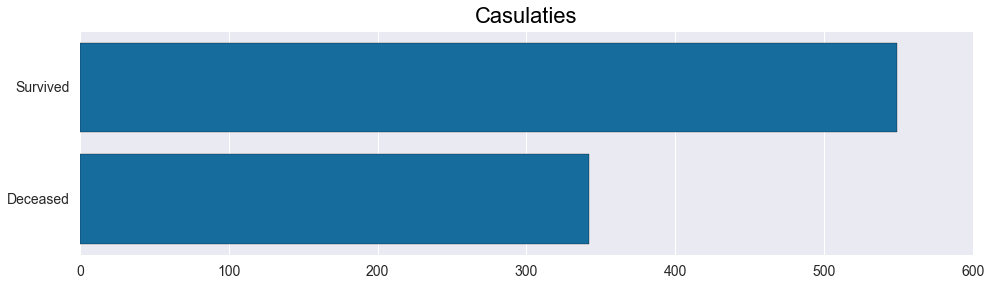

In [149]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 4), sharex=True)
ax1.tick_params(labelsize=14, pad=10)
ax1.set_title('Casulaties', fontdict=title_font)

sns.barplot(y=['Survived','Deceased'], 
            x = dfa.Survived.value_counts().values, 
            ax=ax1, color=current_palette[0])

ax1.legend(ncol=2, loc="lower right", frameon=True, fontsize=14)

### 1.2 Survie en fonction du sexe

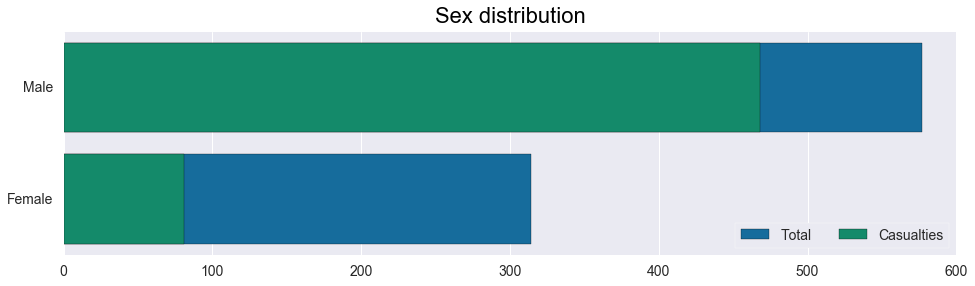

In [150]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 4), sharex=True)
ax1.tick_params(labelsize=14, pad=10)
ax1.set_title('Sex distribution', fontdict=title_font)

sns.barplot(y=['Male', 'Female'], 
            x = dfa.Sex.value_counts().values, 
            ax=ax1, color=current_palette[0], label='Total')
sns.barplot(y=['Male', 'Female'], 
            x = dfa[dfa['Survived']==0].Sex.value_counts().values, 
            ax=ax1, color=current_palette[1],
           label='Casualties')

ax1.legend(ncol=2, loc="lower right", frameon=True, fontsize=14)

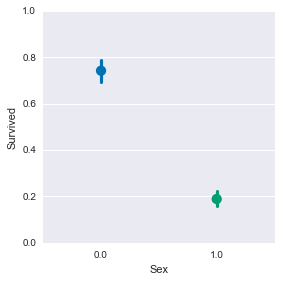

In [158]:
sns.factorplot("Sex", "Survived", data=dfa, palette=current_palette).set(ylim=(0, 1))

### 1.3 Survie en fonction de la classe

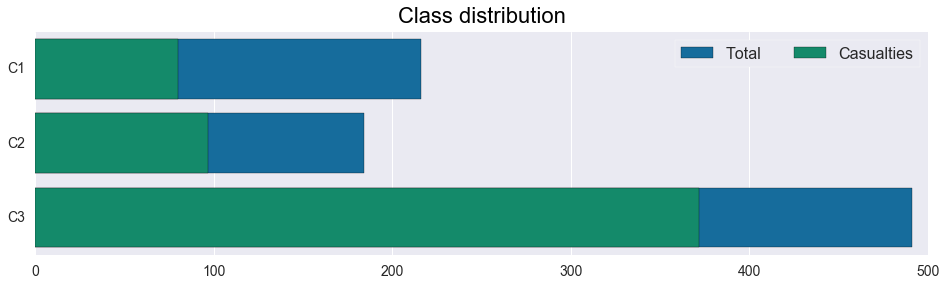

In [152]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 4))
ax1.tick_params(labelsize=14, pad=10)
ax1.set_title('Class distribution', fontdict=title_font)

se = dfa.Pclass.value_counts(sort=False)
se.index = ['C1', 'C2', 'C3']

sns.barplot(y = se.index, 
            x = se.values, 
            ax=ax1, color=current_palette[0], label='Total')

se = dfa[dfa['Survived']==0].Pclass.value_counts(sort=False)
se.index = ['C1', 'C2', 'C3']
sns.barplot(y = se.index, 
            x = se.values, 
            ax=ax1, color=current_palette[1], label='Casualties')

ax1.legend(ncol=2, loc="upper right", frameon=True, fontsize=16)

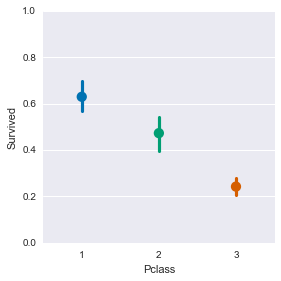

In [161]:
sns.factorplot('Pclass','Survived', data=dfa, palette=current_palette).set(ylim=(0, 1))

On regarde maintenant les taux de survie des différents sexes au sein d'une même classe.

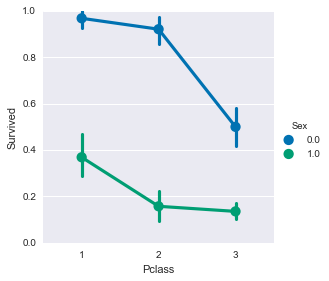

In [162]:
sns.factorplot('Pclass', 'Survived', data=dfa, hue='Sex', palette=current_palette).set(ylim=(0, 1))

### 1.4 Survie en fonction de l'âge

On répartit les passagers en tranche d'âge de 5 ans pour une meilleure visualisation des données.

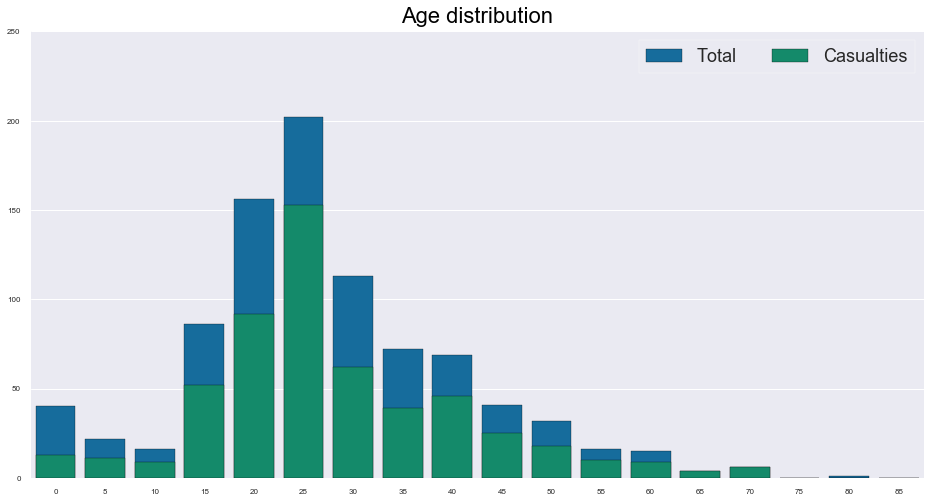

In [156]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 8), sharex=True)
ax1.tick_params(labelsize=8, pad=10)
ax1.set_title('Age distribution', fontdict=title_font)

age_dfa = pd.DataFrame(columns=['Total', 'Casualties'], index=range(int(dfa.Age.min()), int(dfa.Age.max()+6),5))

for i in age_dfa.index:
    age_dfa.loc[i, 'Total'] = ((dfa['Age']>=i)&(dfa['Age']<i+5)).sum()
    age_dfa.loc[i, 'Casualties'] = ((dfa['Age']>=i)&(dfa['Age']<i+5)&(dfa['Survived']==0)).sum()

sns.barplot(y = age_dfa.Total.values, 
            x = age_dfa.index, ax=ax1, color=current_palette[0], label='Total')
sns.barplot(y = age_dfa.Casualties.values,
            x = age_dfa.index, ax=ax1, color=current_palette[1],
            label='Casualties')


ax1.legend(ncol=2, loc="upper right", frameon=True, fontsize=18)

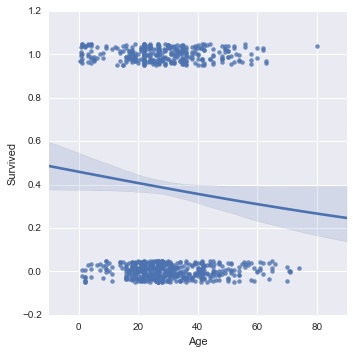

In [163]:
sns.lmplot("Age", "Survived", dfa, logistic=True, y_jitter=.05, palette=current_palette)

On regarde l'impact du sexe sur la variation du taux de survie en fonction de l'âge.

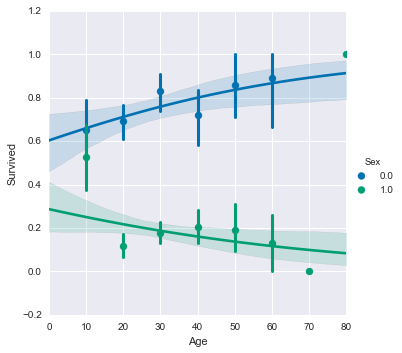

In [166]:
age_bins = [10, 20, 30, 40, 50, 60, 70, 80] 
sns.lmplot("Age", "Survived", dfa, hue="Sex",
           palette=current_palette, x_bins=age_bins, logistic=True).set(xlim=(0, 80))

On s'intéresse aussi à l'influence de la classe sur le taux de survie en fonction de l'âge.

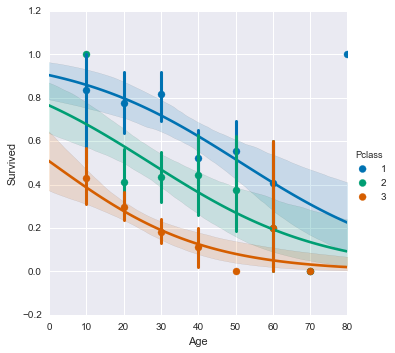

In [167]:
sns.lmplot("Age", "Survived", dfa, hue="Pclass",
           palette=current_palette, x_bins=age_bins, logistic=True).set(xlim=(0, 80))

### 1.5 Survie en fonction du prix du billet

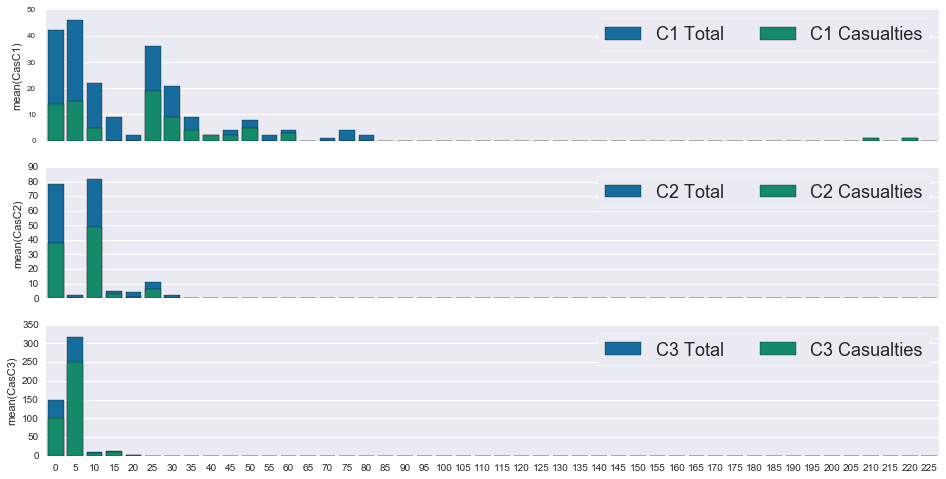

In [168]:
dfa.Fare = dfa.Fare.map(lambda x: int(x))

fare_max = int(dfa.Fare.max())
fare_min = int(dfa.Fare.min())

fare_dfa = pd.DataFrame(columns=['C1','C2','C3','CasC1','CasC2','CasC3'], index = range(fare_min, fare_max+6,5))
for i in fare_dfa.index: 
    fare_dfa.loc[i, 'C1'] = (((dfa['Fare']>=i)&(dfa['Fare']<i+5)&(dfa['Pclass']==1)).sum())
    fare_dfa.loc[i, 'C2'] = (((dfa['Fare']>=i)&(dfa['Fare']<i+5)&(dfa['Pclass']==2)).sum())
    fare_dfa.loc[i, 'C3'] = (((dfa['Fare']>=i)&(dfa['Fare']<i+5)&(dfa['Pclass']==3)).sum())
    fare_dfa.loc[i, 'CasC1'] = (((dfa['Fare']>=i)&(dfa['Fare']<i+5)&(dfa['Pclass']==1)&(dfa['Survived']==0)).sum())
    fare_dfa.loc[i, 'CasC2'] = (((dfa['Fare']>=i)&(dfa['Fare']<i+5)&(dfa['Pclass']==2)&(dfa['Survived']==0)).sum())
    fare_dfa.loc[i, 'CasC3'] = (((dfa['Fare']>=i)&(dfa['Fare']<i+5)&(dfa['Pclass']==3)&(dfa['Survived']==0)).sum())

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 8), sharex=True)
ax1.tick_params(labelsize=8, pad=10)

sns.barplot(y = fare_dfa['C1'],
            x = fare_dfa.index, ax=ax1, color=current_palette[0],
            label='C1 Total')
sns.barplot(y = fare_dfa['CasC1'],
            x = fare_dfa.index, ax=ax1, color=current_palette[1],
            label='C1 Casualties')
sns.barplot(y = fare_dfa['C2'],
            x = fare_dfa.index, ax=ax2, color=current_palette[0],
            label='C2 Total')
sns.barplot(y = fare_dfa['CasC2'],
            x = fare_dfa.index, ax=ax2, color=current_palette[1],
            label='C2 Casualties')
sns.barplot(y = fare_dfa['C3'],
            x = fare_dfa.index, ax=ax3, color=current_palette[0],
            label='C3 Total')
sns.barplot(y = fare_dfa['CasC3'],
            x = fare_dfa.index, ax=ax3, color=current_palette[1],
            label='C3 Casualties')

ax1.legend(ncol=2, loc="upper right", frameon=True, fontsize=18)
ax2.legend(ncol=2, loc="upper right", frameon=True, fontsize=18)
ax3.legend(ncol=2, loc="upper right", frameon=True, fontsize=18)

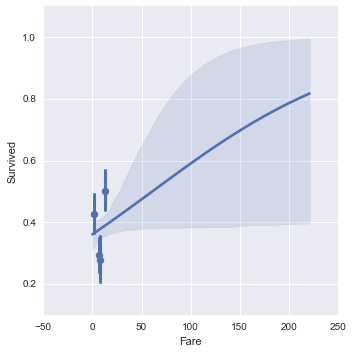

In [170]:
sns.lmplot("Fare", "Survived", dfa, x_bins=4, logistic=True, truncate=True, palette=current_palette)

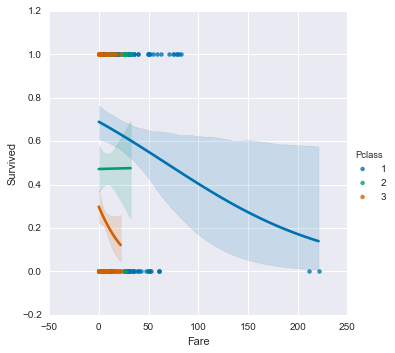

In [171]:
sns.lmplot("Fare", "Survived", dfa, hue="Pclass", logistic=True, truncate=True, palette=current_palette);

### 1.6 Survie en fonction de l'emplacement de la cabine

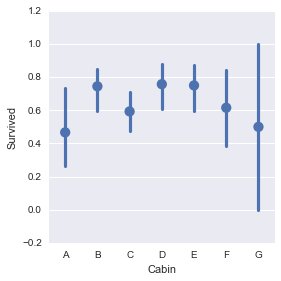

In [172]:
sns.factorplot('Cabin', 'Survived', data=dfa, order='ABCDEFG', join=False);

### 1.7 Survie en fonction du nombre de relations familiales

Dans un premier temps, on regarde la variation du taux de survie en fonction du paramètre que nous avons crée, le nombre total de relations familiales.

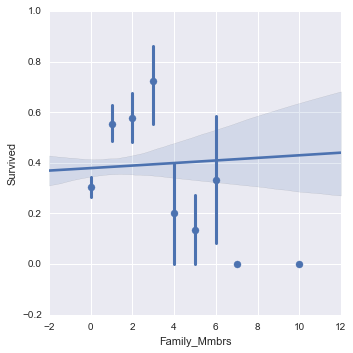

In [9]:
sns.lmplot('Family_Mmbrs', 'Survived', dfa, x_estimator=np.mean, logistic=True, palette=current_palette)

On observe maintenant l'effet du sexe sur cette variation.

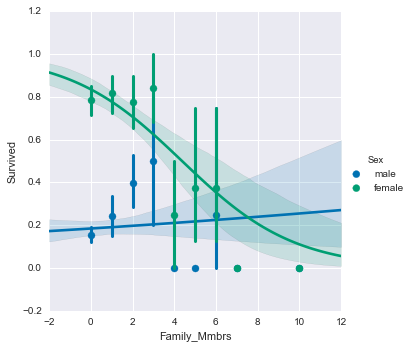

In [24]:
sns.lmplot('Family_Mmbrs', 'Survived', dfa, hue="Sex", x_estimator=np.mean, logistic=True, palette=current_palette)

### 1.8 Survie en fonction du port d'embarcation

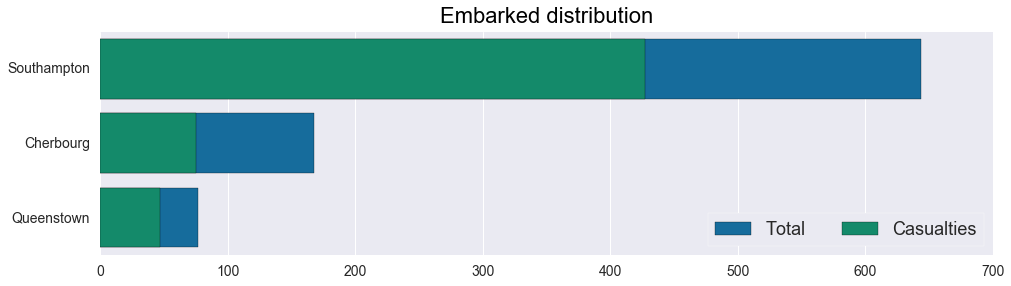

In [239]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 4), sharex=True)
ax1.tick_params(labelsize=14, pad=10)
ax1.set_title('Embarked distribution', fontdict=title_font)

sns.barplot(y=['Southampton', 'Cherbourg', 'Queenstown'], 
            x = dfa.Embarked.value_counts().values, ax=ax1, color=current_palette[0], label='Total')
sns.barplot(y=['Southampton', 'Cherbourg', 'Queenstown'],
            x = dfa[dfa['Survived']==0].Embarked.value_counts().values, ax=ax1, color=current_palette[1],
            label='Casualties')

ax1.legend(ncol=2, loc="lower right", frameon=True, fontsize=18)

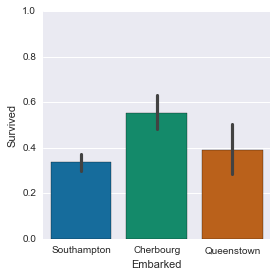

In [30]:
sns.factorplot('Embarked','Survived', data=dfa, kind="bar", palette=current_palette).set(ylim=(0, 1))

### 1.9 Survie en fonction du titre honorofique

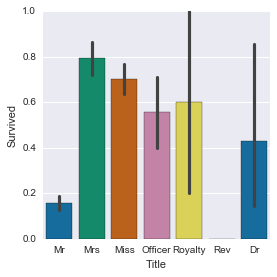

In [33]:
sns.factorplot('Title','Survived', data=dfa, kind="bar", palette=current_palette).set(ylim=(0, 1))

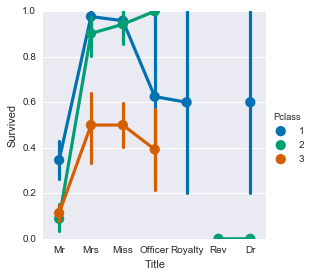

In [34]:
sns.factorplot('Title', 'Survived', data=dfa, hue='Pclass', palette=current_palette).set(ylim=(0, 1))

## 2 Machine Learning/Modélisation

In [10]:
predicted = 'Survived'

In [11]:
def data_prep(df, drop=True):
    
    title_d = {'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master':'Officer', 'Dr':'Dr', 
           'Rev':'Rev', 'Major':'Officer', 'Col':'Officer', 'Mlle': 'Miss', 'Jonkheer':'Royalty',
           'Ms': 'Miss', 'Don':'Royalty', 'Mme':'Mrs', 'Capt':'Officer', 'Lady':'Royalty', 'theCountess': 'Royalty',
           'Dona':'Royalty', 'Sir':'Royalty'}
    
    passenger_ticket_d = df.groupby('Ticket')['Fare'].count().to_dict()
    ticket_fare_d = (df.groupby('Ticket')['Fare'].mean()/df.groupby('Ticket')['Fare'].count()).to_dict()
    
    df['MissingInfo'] = df.isnull().sum(axis=1)
    
    # sex
    df.loc[df["Sex"] == "male", "Sex"] = 0.
    df.loc[df["Sex"] == "female", "Sex"] = 1.

    # embarked
    df.loc[df['Embarked'] == "S", "Embarked_S"] = 1.
    df.loc[df['Embarked'] != "S", "Embarked_S"] = 0.
    df.loc[df['Embarked'] == "C", "Embarked_C"] = 1.
    df.loc[df['Embarked'] != "C", "Embarked_C"] = 0.

    # class 
    df.loc[df['Pclass'] == 1, "Pclass_1"] = 1.
    df.loc[df['Pclass'] != 1, "Pclass_1"] = 0.
    df.loc[df['Pclass'] == 2, "Pclass_2"] = 1.
    df.loc[df['Pclass'] != 2, "Pclass_2"] = 0.
    
    # age 
    for pclass in [1,2,3]: 
        for sex in [0,1]: 
            age_filter = (df['Pclass']==pclass)&(df['Sex']==sex)
            df.loc[(df['Age'].isnull())&age_filter,'Age'] = (df[(df['Age']>0)&age_filter])['Age'].mean()

    df.loc[:,'Intercept'] = 1.
    
    # fare 
    df['Fare'] = df['Ticket'].map(lambda x: ticket_fare_d[x]) 
    
    df.loc[(df['Pclass']==1)&df['Fare'].isnull(),'Fare'] = (df[df['Pclass']==1])['Fare'].mean()
    df.loc[(df['Pclass']==2)&df['Fare'].isnull(),'Fare'] = (df[df['Pclass']==2])['Fare'].mean()
    df.loc[(df['Pclass']==3)&df['Fare'].isnull(),'Fare'] = (df[df['Pclass']==3])['Fare'].mean()
    
    # title 
    df.loc[:, 'Title'] = df.Name.map(lambda x: title_d[x.split(',')[1].split('.')[0].replace(' ','')])
    title_df = pd.get_dummies(df['Title'], prefix='Title')
    
    df[title_df.columns] = title_df
    
    # family 
    df['Family_Member'] = df['SibSp'] + df['Parch']
    # passenger per ticket 
    df['Ticket_Party'] = df['Ticket'].map(lambda x: passenger_ticket_d[x])
    
    # ticket prefix 
    df.loc[:,'Cabin'] = df.Cabin.map(lambda x: x[0] if type(x)==str else 'NoClue')
    cabin_df = pd.get_dummies(df['Cabin'], prefix='Cabin')
    df[cabin_df.columns] = cabin_df
    
    
    df['Parch'] =  df['Parch'].map(lambda x: float(x))
    df['SibSp'] =  df['SibSp'].map(lambda x: float(x))
    df.Family_Member = df.Family_Member.map(lambda x: float(x))
    df.Sex = df.Sex.map(lambda x: float(x))
    
    return df 

#### Données de training

In [12]:
df = pd.read_csv("data/train.csv")
df = data_prep(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 37 columns):
PassengerId      891 non-null int64
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null float64
Age              891 non-null float64
SibSp            891 non-null float64
Parch            891 non-null float64
Ticket           891 non-null object
Fare             891 non-null float64
Cabin            891 non-null object
Embarked         889 non-null object
MissingInfo      891 non-null int64
Embarked_S       891 non-null float64
Embarked_C       891 non-null float64
Pclass_1         891 non-null float64
Pclass_2         891 non-null float64
Intercept        891 non-null float64
Title            891 non-null object
Title_Dr         891 non-null float64
Title_Miss       891 non-null float64
Title_Mr         891 non-null float64
Title_Mrs        891 non-null float64
Title_Officer    891 non-null floa

#### Données Test

In [22]:
test_df = pd.read_csv("data/test.csv")
test_df = data_prep(test_df)

#### Prédicteurs

In [13]:
predictors_l =[ u'Sex', u'Age', u'SibSp', u'Parch', u'Fare',
                u'MissingInfo', u'Embarked_S', u'Embarked_C', u'Pclass_1', 
                u'Pclass_2', u'Intercept', u'Title_Dr', u'Title_Miss', u'Title_Mr', u'Title_Mrs',
                u'Title_Officer', u'Title_Rev', u'Title_Royalty', u'Ticket_Party',
                u'Cabin_A', u'Cabin_B', u'Cabin_C', u'Cabin_D', u'Cabin_E', u'Cabin_F', u'Cabin_G', u'Cabin_NoClue']

### 2.1 Régression logistique

#### 2.1.1 Definition du passager de référence

On choisit comme passager de référence un homme avec le titre "Mr", voyageant seul en troisième classe, sans indication de cabine, et ayant payé le prix moyen pour son billet.

In [14]:
rg_predictors_l = [ u'Intercept',
                  u'Sex', u'Age', u'SibSp', u'Parch', u'Fare',
                  u'MissingInfo', u'Embarked_S', u'Embarked_C', u'Pclass_1', u'Pclass_2', 
                  u'Title_Dr', u'Title_Miss', u'Title_Mrs', u'Title_Officer', u'Title_Rev', u'Title_Royalty', u'Ticket_Party',
                  u'Cabin_A', u'Cabin_B', u'Cabin_C', u'Cabin_D', u'Cabin_E', u'Cabin_F', u'Cabin_G']

#### 2.1.2 Fit Model 

In [15]:
logreg = linear_model.LogisticRegression(random_state=1)
scores = cross_validation.cross_val_score(logreg, df[rg_predictors_l], df[predicted], cv=3)
scores.mean()

0.82603815937149283

In [16]:
x = df[rg_predictors_l]
y = pd.DataFrame(df[predicted])

y = np.asarray(y)
y = y.flatten()

logreg = linear_model.LogisticRegression(random_state=1, solver='liblinear')
rg_results = logreg.fit(x, y)

score = rg_results.score(x, y)

score

0.83389450056116721

#### 2.1.3 Interprétation du modèle

In [17]:
inter_se = pd.Series(logreg.coef_[0], index=rg_predictors_l)
inter_se

Intercept       -0.298557
Sex              2.146597
Age             -0.037582
SibSp           -0.492701
Parch           -0.332203
Fare             0.005239
MissingInfo     -0.307110
Embarked_S      -0.469514
Embarked_C       0.046311
Pclass_1         1.528016
Pclass_2         0.971287
Title_Dr         0.296493
Title_Miss       0.473298
Title_Mrs        1.306715
Title_Officer    2.226628
Title_Rev       -0.521806
Title_Royalty    0.230742
Ticket_Party     0.078818
Cabin_A          0.222061
Cabin_B          0.272833
Cabin_C          0.005683
Cabin_D          0.806010
Cabin_E          1.073874
Cabin_F          0.345562
Cabin_G         -0.464578
dtype: float64

**a. Probabilité de survie du passager de référence**

#### Cross validation

In [18]:
coeff = inter_se['Intercept']

np.exp(coeff)/(1+np.exp(coeff))

0.42591019766944538

**b. Probabilité de survie du passager de référence si Dr.**

In [19]:
coeff = inter_se['Intercept'] + inter_se['Title_Dr']

np.exp(coeff)/(1+np.exp(coeff))

0.49948397602085098

**c. Probablilté de survie du passager de référence si vieux de 10 ans en plus et si Dr.**

In [20]:
coeff = inter_se['Intercept'] + inter_se['Title_Dr'] + 10.*inter_se['Age']

np.exp(coeff)/(1+np.exp(coeff))

0.40663756960502517

#### 2.1.4 Predict test result 

In [23]:
test_x = test_df[rg_predictors_l]
rg_predict = rg_results.predict(test_x)

rg_result_df = pd.DataFrame([test_df.PassengerId, rg_predict], index=['PassengerId', "Survived"]).T
rg_result_df.index = rg_result_df['PassengerId']
rg_result_df.drop('PassengerId', axis=1, inplace=True)

rg_result_df.to_csv('rg_test.csv')

### 2.2 SVM

#### 2.2.1 Préparation des données

In [191]:
df = pd.read_csv("data/train.csv")
df = data_prep(df)

test_df = pd.read_csv("data/test.csv")
test_df = data_prep(test_df)

# normalization
for col in ['Age', 'Fare', 'SibSp', 'Parch', u'Ticket_Party', 'MissingInfo']:
    df[col] = (df[col])/(df[col].max() - df[col].min())
    test_df[col] = (test_df[col])/(test_df[col].max() - test_df[col].min())

#### 2.2.2 Mise en place des paramètres

#### a. Processus Itératif

In [193]:
score_d = {}
cross_score_d = {}

In [194]:
parameter_d = {'C' : [10**x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4]], 
               'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 
               'gamma' : [0.01, 0.1, 1, 10, 100],
               }

In [195]:
key = 'gamma'
score_l =[]
cross_score_l = []

for parameter in parameter_d[key]: 
        
        svm_model = svm.SVC(gamma=parameter)

        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        y = np.asarray(y)
        y = y.flatten()

        svm_results = svm_model.fit(x,y)

        score = svm_results.score(x, y)
        score_l +=[score]

        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        
        kf = KFold(df.shape[0], n_folds=3, random_state=1)
        predictions = []
        for train, test in kf:
            train_predictors = (df[predictors_l].iloc[train,:])
            train_target = df[predicted].iloc[train]
            # scm friendly conversion 
            train_target = np.asarray(train_target)
            train_target = train_target.flatten()  

            svm_model = svm.SVC(gamma=parameter)
            
            svm_res = svm_model.fit(train_predictors ,train_target)
            test_predictions = svm_res.predict(df[predictors_l].iloc[test,:])
            predictions.append(test_predictions)
            
        prediction = np.concatenate(predictions)
        svm_accuracy = (df['Survived'] == prediction).sum()*1./len(df)  
        cross_score_l += [svm_accuracy]
            
score_d[key] = score_l
cross_score_d[key] = cross_score_l

In [196]:
key = 'C'
score_l =[]
cross_score_l = []

for parameter in parameter_d[key]: 
        
        svm_model = svm.SVC(C=parameter)

        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        y = np.asarray(y)
        y = y.flatten()

        svm_results = svm_model.fit(x,y)

        score = svm_results.score(x, y)
        score_l +=[score]

        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        
        kf = KFold(df.shape[0], n_folds=3, random_state=1)
        predictions = []
        for train, test in kf:
            train_predictors = (df[predictors_l].iloc[train,:])
            train_target = df[predicted].iloc[train]
            # scm friendly conversion 
            train_target = np.asarray(train_target)
            train_target = train_target.flatten()  

            svm_model = svm.SVC(C=parameter)
            
            svm_res = svm_model.fit(train_predictors ,train_target)
            test_predictions = svm_res.predict(df[predictors_l].iloc[test,:])
            predictions.append(test_predictions)
            
        prediction = np.concatenate(predictions)
        svm_accuracy = (df['Survived'] == prediction).sum()*1./len(df)  
        cross_score_l += [svm_accuracy]
            
score_d[key] = score_l
cross_score_d[key] = cross_score_l

print score_l, cross_score_l

[0.61616161616161613, 0.61616161616161613, 0.61616161616161613, 0.7912457912457912, 0.80695847362514028, 0.83613916947250277, 0.84960718294051629, 0.8709315375982043, 0.89562289562289565] [0.61616161616161613, 0.61616161616161613, 0.61616161616161613, 0.79236812570145898, 0.78114478114478114, 0.82267115600448937, 0.82379349046015715, 0.81369248035914699, 0.8125701459034792]


In [197]:
key = 'kernel'
score_l =[]
cross_score_l = []

for parameter in parameter_d[key]: 
        
        svm_model = svm.SVC(kernel=parameter)

        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        y = np.asarray(y)
        y = y.flatten()

        svm_results = svm_model.fit(x,y)

        score = svm_results.score(x, y)
        score_l +=[score]

        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        
        kf = KFold(df.shape[0], n_folds=3, random_state=1)
        predictions = []
        for train, test in kf:
            train_predictors = (df[predictors_l].iloc[train,:])
            train_target = df[predicted].iloc[train]
            # scm friendly conversion 
            train_target = np.asarray(train_target)
            train_target = train_target.flatten()  

            svm_model = svm.SVC(kernel=parameter)
            
            svm_res = svm_model.fit(train_predictors ,train_target)
            test_predictions = svm_res.predict(df[predictors_l].iloc[test,:])
            predictions.append(test_predictions)
            
        prediction = np.concatenate(predictions)
        svm_accuracy = (df['Survived'] == prediction).sum()*1./len(df)  
        cross_score_l += [svm_accuracy]
            
score_d[key] = score_l
cross_score_d[key] = cross_score_l

print score_l, cross_score_l

[0.83726150392817056, 0.61616161616161613, 0.80695847362514028, 0.61616161616161613] [0.81930415263748602, 0.61616161616161613, 0.78114478114478114, 0.61616161616161613]


In [198]:
title_font = {'fontname':'Arial', 'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
sub_title_font = {'fontname':'Arial', 'size':'18', 'color':'black', 'weight':'normal'}

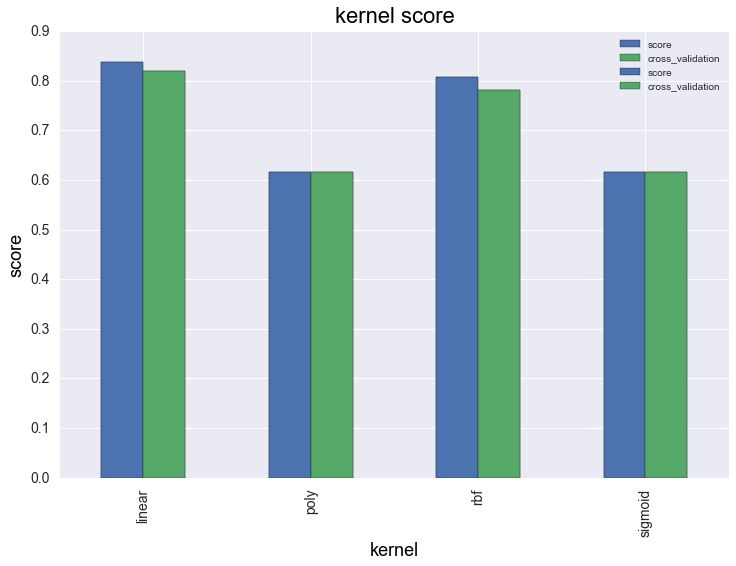

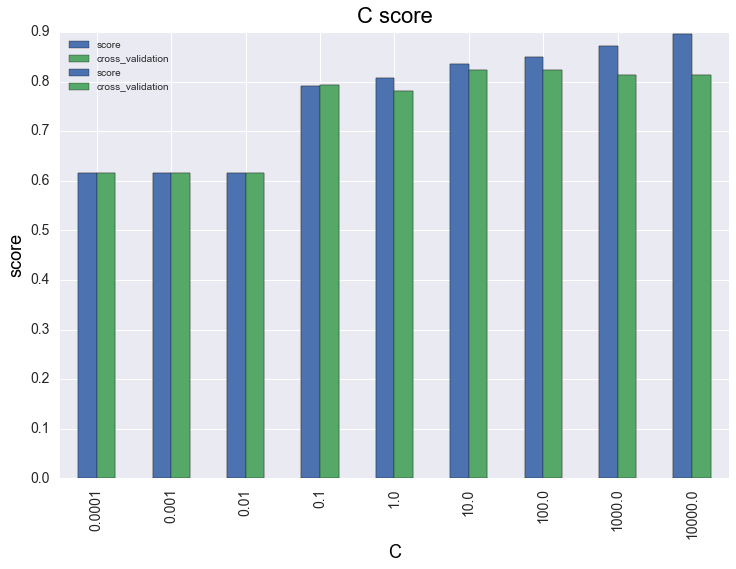

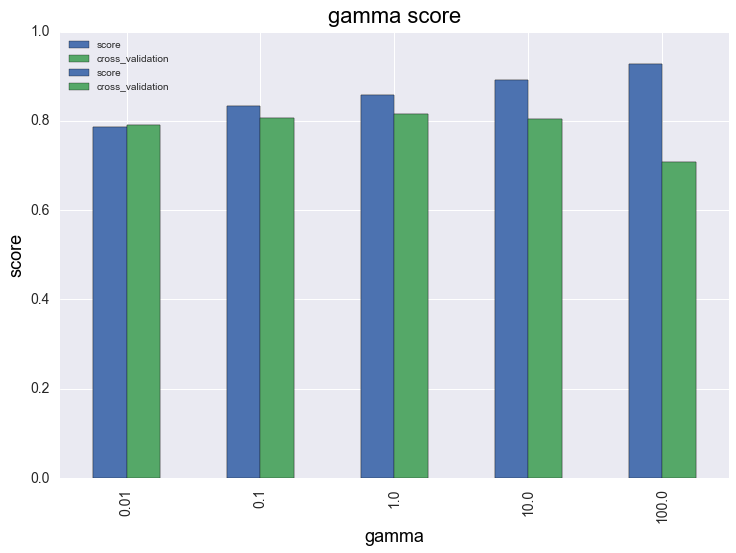

In [199]:
for param in ['kernel', 'C', 'gamma']:
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 8), sharex ='none')

    ax1.tick_params(labelsize=14, pad=10)
    ax1.set_title('%s score' % param, fontdict=title_font)
    ax1.set_ylabel('score', fontdict=sub_title_font)
    ax1.set_xlabel(param, fontdict=sub_title_font)

    score_df = pd.DataFrame([score_d[param], cross_score_d[param]], 
                            index = ['score', 'cross_validation'], 
                            columns=parameter_d[param]).T

    score_df.plot(ax=ax1, kind='bar')
    
    plot = score_df.plot(ax=ax1, kind='bar')

On utilise GridSearchCV pour chercher la meilleure combinaison 

##### b. Paramétrage du modèle

In [203]:
C = 100
gamma = 0.002
kernel = 'rbf'

#### 3 - Fit Model 

In [209]:
# cross validation 

x = df[predictors_l]
y = pd.DataFrame(df[predicted])
        
kf = KFold(df.shape[0], n_folds=3, random_state=1)
predictions = []
for train, test in kf:
            train_predictors = (df[predictors_l].iloc[train,:])
            train_target = df[predicted].iloc[train]
            # scm friendly conversion 
            train_target = np.asarray(train_target)
            train_target = train_target.flatten()  

            svm_model = svm.SVC(C=C, gamma=gamma, kernel=kernel)
            
            svm_res = svm_model.fit(train_predictors ,train_target)
            test_predictions = svm_res.predict(df[predictors_l].iloc[test,:])
            predictions.append(test_predictions)
            
prediction = np.concatenate(predictions)
svm_accuracy = (df['Survived'] == prediction).sum()*1./len(df)  

In [210]:
# train all training set 

svm_model = svm.SVC(C=C, gamma=gamma, kernel=kernel)

x = df[predictors_l]
y = pd.DataFrame(df[predicted])
y = np.asarray(y)
y = y.flatten()

svm_results = svm_model.fit(x,y)

score = svm_results.score(x, y)

score

0.83052749719416386

In [207]:
#### 4 - Predict test result 

In [208]:
test_x = test_df[predictors_l]
svm_predict = svm_results.predict(test_x)

svm_result_df = pd.DataFrame([test_df.PassengerId, svm_predict], index=['PassengerId', "Survived"]).T
svm_result_df.index = svm_result_df['PassengerId']
svm_result_df.drop('PassengerId', axis=1, inplace=True)

svm_result_df.to_csv('svm_test.csv')

### 2.3 Decision Tree

In [89]:
dt_model = tree.DecisionTreeClassifier(criterion='entropy')
dt_model.max_depth = 5
dt_model.min_samples_split = 1

x = df[predictors_l]

y = pd.DataFrame(df[predicted])
y = np.asarray(y)
y = y.flatten()

dt_model.fit(x, y)

score = dt_model.score(x, y)

score

0.83277216610549942

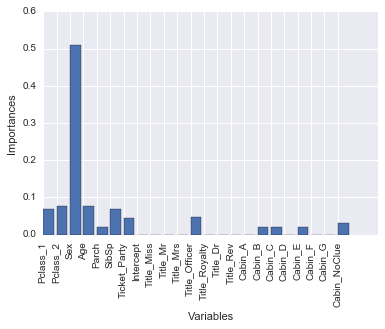

In [99]:
N = len(predictors_l)
ind = np.arange(N)
plt.bar(ind,dt_model.feature_importances_)
plt.xticks(ind, predictors_l, rotation='vertical')
plt.ylabel('Importances')
plt.xlabel('Variables')

On trace l'arbre de décision

In [92]:
import os

with open("titanictree.dot", 'w') as f:
    f = tree.export_graphviz(dt_results, feature_names=predictors_l, filled=True, rounded=True, out_file=f)
    
os.system('dot -Tpng titanictree.dot -o titanictree.png')
    

0

#### Test de prediction 

In [12]:
test_x = test_df[predictors_l]

In [14]:
dt_predict = dt_results.predict(test_x)

In [15]:
result_df = pd.DataFrame([test_df.PassengerId, dt_predict], index=['PassengerId', "Survived"]).T
result_df.index = result_df['PassengerId']
result_df.drop('PassengerId', axis=1, inplace=True)

In [16]:
result_df.to_csv('dt_test.csv')

#### cross validation

In [95]:
kf = KFold(df.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_predictors = (df[predictors_l].iloc[train,:])
    train_target = df[predicted].iloc[train]
    
    # scm friendly conversion 
    train_target = np.asarray(train_target)
    train_target = train_target.flatten()  
    
    dt_model = tree.DecisionTreeClassifier(criterion='entropy')
    dt_model.max_depth = 5
    dt_model.min_samples_split = 1
    
    # Training the algorithm using the predictors and target.
    dt_res = dt_model.fit(train_predictors ,train_target)
    # We can now make predictions on the test fold
    test_predictions = dt_res.predict(df[predictors_l].iloc[test,:])
    predictions.append(test_predictions)

In [96]:
prediction = np.concatenate(predictions)

dt_accuracy = (df['Survived'] == prediction).sum()*1./len(df)
print dt_accuracy

0.822671156004


In [100]:
kf = KFold(df.shape[0], n_folds=3, random_state=1)

results = []
index = []
for i in range(1,101):
    index.append(i)
    predictions = []
    for train, test in kf:
        train_predictors = (df[predictors_l].iloc[train,:])
        train_target = df[predicted].iloc[train]
    
        # scm friendly conversion 
        train_target = np.asarray(train_target)
        train_target = train_target.flatten()  
    
        dt_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i)
        # Training the algorithm using the predictors and target.
        dt_res = dt_model.fit(train_predictors ,train_target)
        # We can now make predictions on the test fold
        test_predictions = dt_res.predict(df[predictors_l].iloc[test,:])
        predictions.append(test_predictions)
    prediction = np.concatenate(predictions)
    dt_accuracy = (df['Survived'] == prediction).sum()*1./len(df)
    results.append(dt_accuracy)

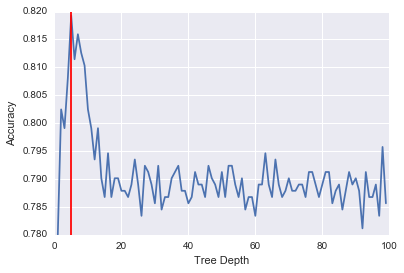

In [112]:
results = np.array(results)
best_depth = results.argmax()+1

plt.plot(index,results)
plt.ylabel('Accuracy')
plt.xlabel('Tree Depth')
plt.axvline(x=best_depth, color='r')

### 2.4 Random Forest 

#### 2.4.1 Préparation des données

In [24]:
df = pd.read_csv("data/train.csv")
df = data_prep(df)

test_df = pd.read_csv("data/test.csv")
test_df = data_prep(test_df)

**Processus Itératif**

In [25]:
rf_score_d = {}
rf_cross_score_d = {}

In [26]:
rf_parameter_d = {'n_estimators' : [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
                  'max_features' : ['auto', 'sqrt', 'log2', None], 
                  'max_depth' : [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
                  'min_samples_split' : [1, 2, 4, 8, 16, 32, 64],
                  'min_samples_leaf' : [1, 2, 4, 8, 16, 32, 64],
                  'min_weight_fraction_leaf' : [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                  'max_leaf_nodes' : [2, 4, 8, 16, 32, 64, 128, 256, 512, None],
               }

In [27]:
key = 'n_estimators'
score_l =[]
cross_score_l = []

for parameter in rf_parameter_d[key]: 
        
        rf_model = ensemble.RandomForestClassifier(n_estimators=parameter)
        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        y = np.asarray(y)
        y = y.flatten()

        rf_results = rf_model.fit(x,y)

        score = rf_results.score(x, y)
        score_l +=[score]

        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        
        kf = KFold(df.shape[0], n_folds=3, random_state=1)
        predictions = []
        for train, test in kf:
            train_predictors = (df[predictors_l].iloc[train,:])
            train_target = df[predicted].iloc[train]
            # scm friendly conversion 
            train_target = np.asarray(train_target)
            train_target = train_target.flatten()  

            rf_model = ensemble.RandomForestClassifier(n_estimators=parameter)
            
            rf_res = rf_model.fit(train_predictors ,train_target)
            test_predictions = rf_res.predict(df[predictors_l].iloc[test,:])
            predictions.append(test_predictions)
            
        prediction = np.concatenate(predictions)
        rf_accuracy = (df['Survived'] == prediction).sum()*1./len(df)  
        cross_score_l += [rf_accuracy]
            
rf_score_d[key] = score_l
rf_cross_score_d[key] = cross_score_l

In [28]:
key = 'max_features'
score_l =[]
cross_score_l = []

for parameter in rf_parameter_d[key]: 
        
        rf_model = ensemble.RandomForestClassifier(max_features=parameter)
        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        y = np.asarray(y)
        y = y.flatten()

        rf_results = rf_model.fit(x,y)

        score = rf_results.score(x, y)
        score_l +=[score]

        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        
        kf = KFold(df.shape[0], n_folds=3, random_state=1)
        predictions = []
        for train, test in kf:
            train_predictors = (df[predictors_l].iloc[train,:])
            train_target = df[predicted].iloc[train]
            # scm friendly conversion 
            train_target = np.asarray(train_target)
            train_target = train_target.flatten()  

            rf_model = ensemble.RandomForestClassifier(max_features=parameter)
            
            rf_res = rf_model.fit(train_predictors ,train_target)
            test_predictions = rf_res.predict(df[predictors_l].iloc[test,:])
            predictions.append(test_predictions)
            
        prediction = np.concatenate(predictions)
        rf_accuracy = (df['Survived'] == prediction).sum()*1./len(df)  
        cross_score_l += [rf_accuracy]
            
rf_score_d[key] = score_l
rf_cross_score_d[key] = cross_score_l

In [29]:
key = 'max_depth'
score_l =[]
cross_score_l = []

for parameter in rf_parameter_d[key]: 
        
        rf_model = ensemble.RandomForestClassifier(max_depth=parameter)
        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        y = np.asarray(y)
        y = y.flatten()

        rf_results = rf_model.fit(x,y)

        score = rf_results.score(x, y)
        score_l +=[score]

        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        
        kf = KFold(df.shape[0], n_folds=3, random_state=1)
        predictions = []
        for train, test in kf:
            train_predictors = (df[predictors_l].iloc[train,:])
            train_target = df[predicted].iloc[train]
            # scm friendly conversion 
            train_target = np.asarray(train_target)
            train_target = train_target.flatten()  

            rf_model = ensemble.RandomForestClassifier(max_depth=parameter)
            
            rf_res = rf_model.fit(train_predictors ,train_target)
            test_predictions = rf_res.predict(df[predictors_l].iloc[test,:])
            predictions.append(test_predictions)
            
        prediction = np.concatenate(predictions)
        rf_accuracy = (df['Survived'] == prediction).sum()*1./len(df)  
        cross_score_l += [rf_accuracy]
            
rf_score_d[key] = score_l
rf_cross_score_d[key] = cross_score_l

In [30]:
key = 'min_samples_split'
score_l =[]
cross_score_l = []

for parameter in rf_parameter_d[key]: 
        
        rf_model = ensemble.RandomForestClassifier(min_samples_split=parameter)
        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        y = np.asarray(y)
        y = y.flatten()

        rf_results = rf_model.fit(x,y)

        score = rf_results.score(x, y)
        score_l +=[score]

        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        
        kf = KFold(df.shape[0], n_folds=3, random_state=1)
        predictions = []
        for train, test in kf:
            train_predictors = (df[predictors_l].iloc[train,:])
            train_target = df[predicted].iloc[train]
            # scm friendly conversion 
            train_target = np.asarray(train_target)
            train_target = train_target.flatten()  

            rf_model = ensemble.RandomForestClassifier(min_samples_split=parameter)
            
            rf_res = rf_model.fit(train_predictors ,train_target)
            test_predictions = rf_res.predict(df[predictors_l].iloc[test,:])
            predictions.append(test_predictions)
            
        prediction = np.concatenate(predictions)
        rf_accuracy = (df['Survived'] == prediction).sum()*1./len(df)  
        cross_score_l += [rf_accuracy]
            
rf_score_d[key] = score_l
rf_cross_score_d[key] = cross_score_l

In [31]:
key = 'min_samples_leaf'
score_l =[]
cross_score_l = []

for parameter in rf_parameter_d[key]: 
        
        rf_model = ensemble.RandomForestClassifier(min_samples_leaf=parameter)
        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        y = np.asarray(y)
        y = y.flatten()

        rf_results = rf_model.fit(x,y)

        score = rf_results.score(x, y)
        score_l +=[score]

        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        
        kf = KFold(df.shape[0], n_folds=3, random_state=1)
        predictions = []
        for train, test in kf:
            train_predictors = (df[predictors_l].iloc[train,:])
            train_target = df[predicted].iloc[train]
            # scm friendly conversion 
            train_target = np.asarray(train_target)
            train_target = train_target.flatten()  

            rf_model = ensemble.RandomForestClassifier(min_samples_leaf=parameter)
            
            rf_res = rf_model.fit(train_predictors ,train_target)
            test_predictions = rf_res.predict(df[predictors_l].iloc[test,:])
            predictions.append(test_predictions)
            
        prediction = np.concatenate(predictions)
        rf_accuracy = (df['Survived'] == prediction).sum()*1./len(df)  
        cross_score_l += [rf_accuracy]
            
rf_score_d[key] = score_l
rf_cross_score_d[key] = cross_score_l

In [33]:
key = 'min_weight_fraction_leaf'
score_l =[]
cross_score_l = []

for parameter in rf_parameter_d[key]: 
        
        rf_model = ensemble.RandomForestClassifier(min_weight_fraction_leaf=parameter)
        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        y = np.asarray(y)
        y = y.flatten()

        rf_results = rf_model.fit(x,y)

        score = rf_results.score(x, y)
        score_l +=[score]

        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        
        kf = KFold(df.shape[0], n_folds=3, random_state=1)
        predictions = []
        for train, test in kf:
            train_predictors = (df[predictors_l].iloc[train,:])
            train_target = df[predicted].iloc[train]
            # scm friendly conversion 
            train_target = np.asarray(train_target)
            train_target = train_target.flatten()  

            rf_model = ensemble.RandomForestClassifier(min_weight_fraction_leaf=parameter)
            
            rf_res = rf_model.fit(train_predictors ,train_target)
            test_predictions = rf_res.predict(df[predictors_l].iloc[test,:])
            predictions.append(test_predictions)
            
        prediction = np.concatenate(predictions)
        rf_accuracy = (df['Survived'] == prediction).sum()*1./len(df)  
        cross_score_l += [rf_accuracy]
            
rf_score_d[key] = score_l
rf_cross_score_d[key] = cross_score_l

In [34]:
key = 'max_leaf_nodes'
score_l =[]
cross_score_l = []

for parameter in rf_parameter_d[key]: 
        
        rf_model = ensemble.RandomForestClassifier(max_leaf_nodes=parameter)
        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        y = np.asarray(y)
        y = y.flatten()

        rf_results = rf_model.fit(x,y)

        score = rf_results.score(x, y)
        score_l +=[score]

        x = df[predictors_l]
        y = pd.DataFrame(df[predicted])
        
        kf = KFold(df.shape[0], n_folds=3, random_state=1)
        predictions = []
        for train, test in kf:
            train_predictors = (df[predictors_l].iloc[train,:])
            train_target = df[predicted].iloc[train]
            # scm friendly conversion 
            train_target = np.asarray(train_target)
            train_target = train_target.flatten()  

            rf_model = ensemble.RandomForestClassifier(max_leaf_nodes=parameter)
            
            rf_res = rf_model.fit(train_predictors ,train_target)
            test_predictions = rf_res.predict(df[predictors_l].iloc[test,:])
            predictions.append(test_predictions)
            
        prediction = np.concatenate(predictions)
        rf_accuracy = (df['Survived'] == prediction).sum()*1./len(df)  
        cross_score_l += [rf_accuracy]
            
rf_score_d[key] = score_l
rf_cross_score_d[key] = cross_score_l

In [36]:
title_font = {'fontname':'Arial', 'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
sub_title_font = {'fontname':'Arial', 'size':'18', 'color':'black', 'weight':'normal'}

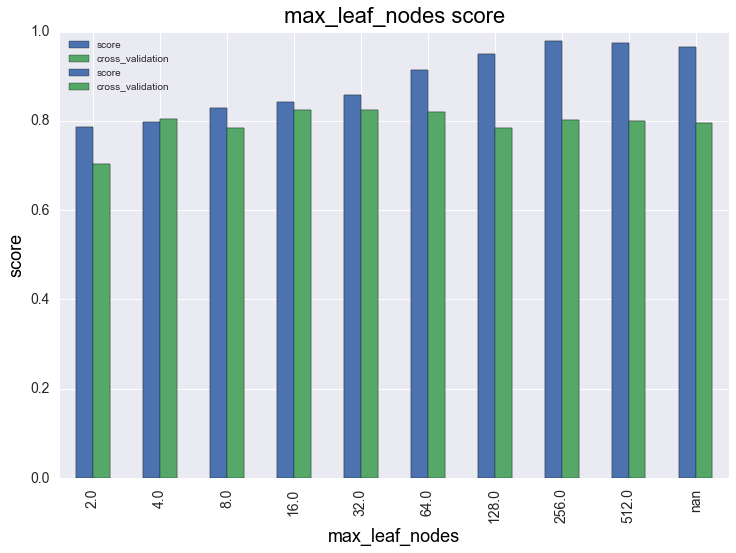

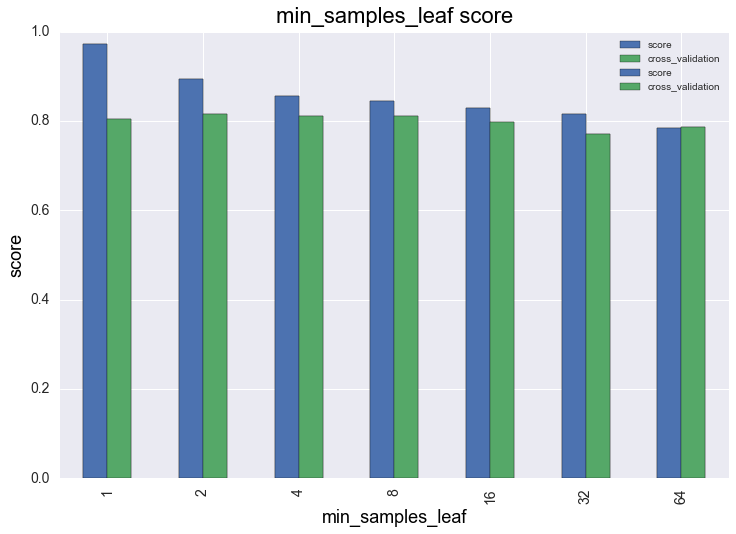

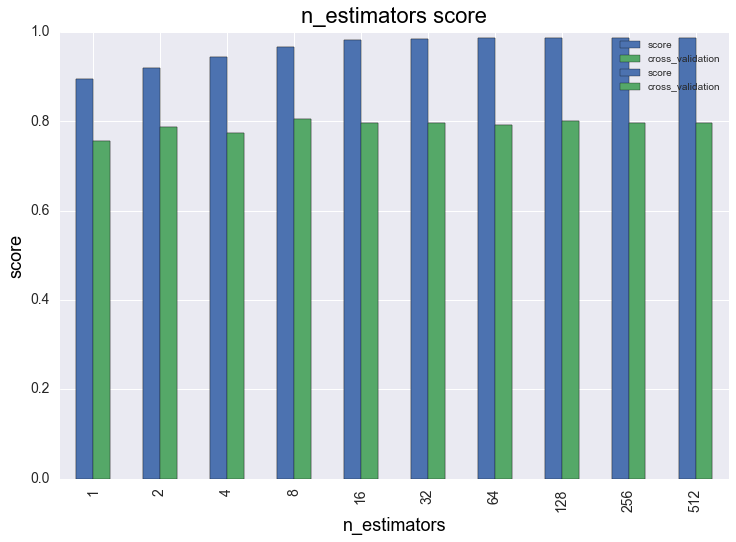

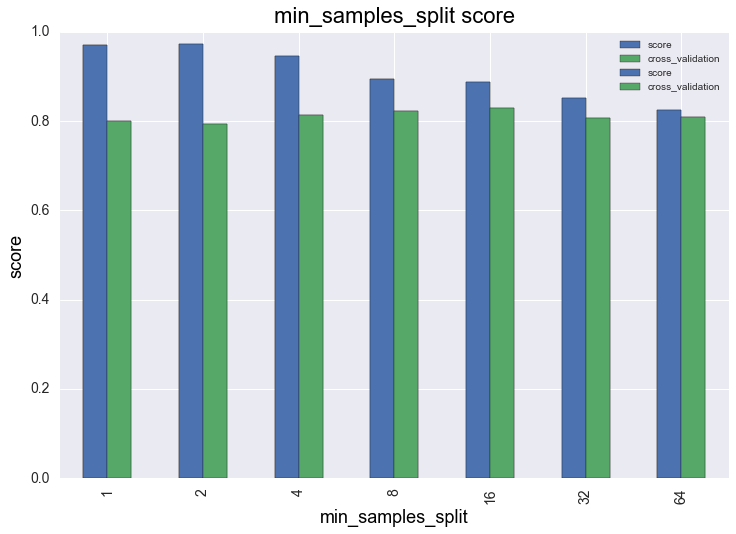

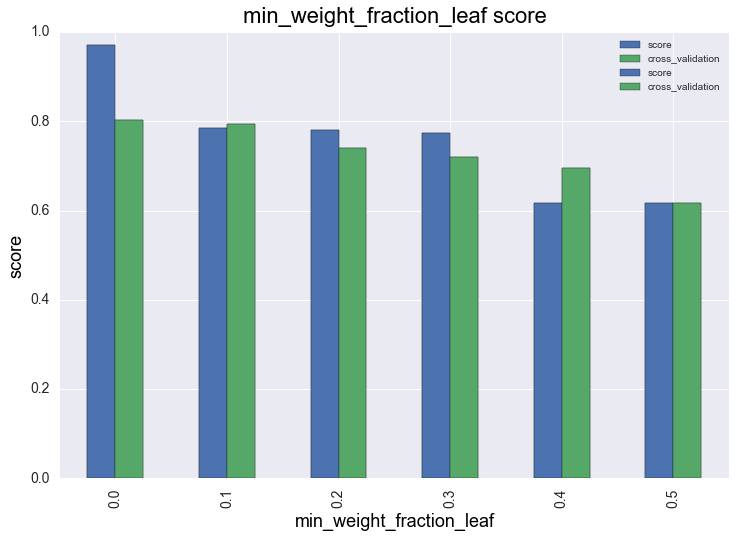

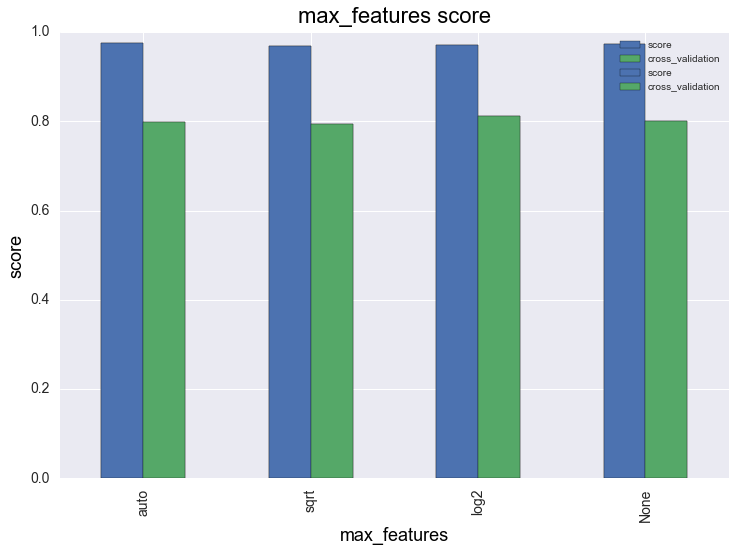

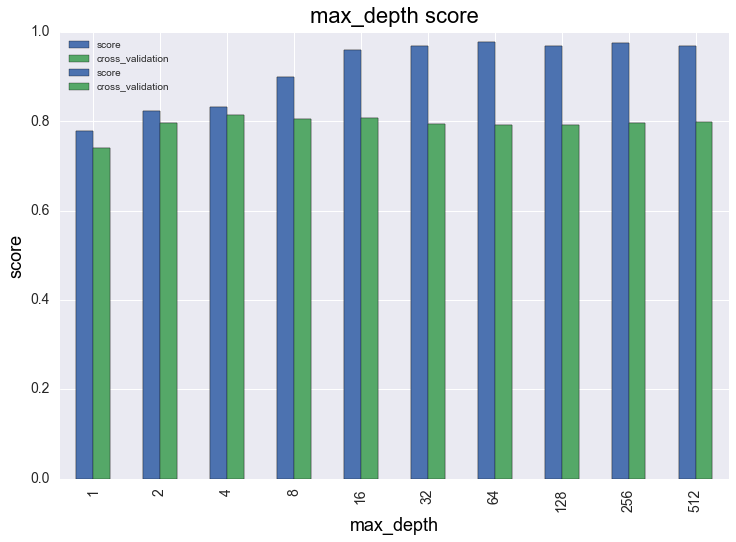

In [37]:
for param in rf_parameter_d.keys():
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 8), sharex ='none')

    ax1.tick_params(labelsize=14, pad=10)
    ax1.set_title('%s score' % param, fontdict=title_font)
    ax1.set_ylabel('score', fontdict=sub_title_font)
    ax1.set_xlabel(param, fontdict=sub_title_font)

    score_df = pd.DataFrame([rf_score_d[param], rf_cross_score_d[param]], 
                            index = ['score', 'cross_validation'], 
                            columns=rf_parameter_d[param]).T

    score_df.plot(ax=ax1, kind='bar')
    
    plot = score_df.plot(ax=ax1, kind='bar')

In [38]:
rf_iter_d = {'max_depth': [32, 40, 48],
             'max_leaf_nodes': [16, 24, 32, 40],
             'min_samples_leaf': [1, 2, 4, 8],
             'min_samples_split': [2, 4, 8, 16, 20],
             'min_weight_fraction_leaf': [0.005, 0.0075, 0.01, 0.0125, 0.015],
             'n_estimators': [32, 40, 48, 56]}

In [ ]:
from sklearn import grid_search

x = df[predictors_l]
y = pd.DataFrame(df[predicted])
y = np.asarray(y)
y = y.flatten()

rf = ensemble.RandomForestClassifier()
clf = grid_search.GridSearchCV(rf, rf_iter_d, n_jobs=10, cv=3)
clf.fit(x,y)

print clf.best_params_
print clf.best_score_

#### 2.4.2 Paramétrisation

In [40]:
max_depth = 16
max_leaf_nodes = 40
min_samples_leaf = 2 
min_samples_split = 16
min_weight_fraction_leaf = 0.0075
n_estimators = 48

#### 2.4.3 Fit Model

In [41]:
# cross validation 

x = df[predictors_l]
y = pd.DataFrame(df[predicted])
        
kf = KFold(df.shape[0], n_folds=3, random_state=1)
predictions = []
for train, test in kf:
            train_predictors = (df[predictors_l].iloc[train,:])
            train_target = df[predicted].iloc[train]
            # rf friendly conversion 
            train_target = np.asarray(train_target)
            train_target = train_target.flatten()  

            rf_model = ensemble.RandomForestClassifier(max_depth=max_depth, 
                                                       max_leaf_nodes=max_leaf_nodes, 
                                                       min_samples_leaf=min_samples_leaf, 
                                                       min_samples_split=min_samples_split,
                                                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                                                       n_estimators=n_estimators)
            rf_res = rf_model.fit(train_predictors ,train_target)
            test_predictions = rf_res.predict(df[predictors_l].iloc[test,:])
            predictions.append(test_predictions)
            
prediction = np.concatenate(predictions)
rf_accuracy = (df['Survived'] == prediction).sum()*1./len(df)  
rf_accuracy

0.82379349046015715

In [42]:
# train all training set 
rf_model = ensemble.RandomForestClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, 
                                           min_samples_leaf=min_samples_leaf, 
                                           min_samples_split=min_samples_split,
                                           min_weight_fraction_leaf=min_weight_fraction_leaf,
                                           n_estimators=n_estimators)

x = df[predictors_l]
y = pd.DataFrame(df[predicted])
y = np.asarray(y)
y = y.flatten()

rf_results = rf_model.fit(x,y)

score = rf_results.score(x, y)

score

0.86644219977553316

#### 2.4.4 Prédiction des résultats test

In [43]:
test_x = test_df[predictors_l]
rf_predict = rf_results.predict(test_x)

rf_result_df = pd.DataFrame([test_df.PassengerId, rf_predict], index=['PassengerId', "Survived"]).T
rf_result_df.index = rf_result_df['PassengerId']
rf_result_df.drop('PassengerId', axis=1, inplace=True)

rf_result_df.to_csv('rf_test.csv')